In [1]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import sunpy.coordinates.sun as sn

import huxt as H
import huxt_analysis as HA
import sir_huxt_mono_obs as sir


mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)


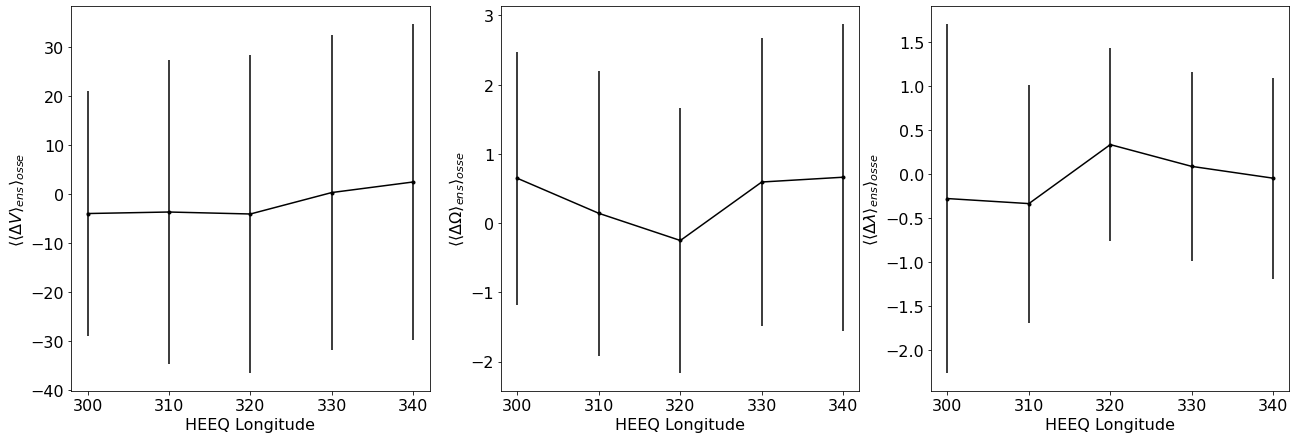

In [2]:
lons = [300, 310, 320, 330, 340]

dv_avg = np.zeros(len(lons))
dv_std = np.zeros(len(lons))
dw_avg = np.zeros(len(lons))
dw_std = np.zeros(len(lons))
dl_avg = np.zeros(len(lons))
dl_std = np.zeros(len(lons))

analysis_key = 'analysis_07'

for i, lon in enumerate(lons):
    dir_tag = 'obs_lon_{}'.format(lon)
    dirs = sir.get_project_dirs()
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)
    
    
    dv_bin = []
    dw_bin = []
    dl_bin = []
    
    for f in files: 

        out_file = h5py.File(f, 'r')
        if analysis_key not in out_file.keys():
            bad_count += 1
            continue
        
        cme_truth_params = out_file['truth_cme_params'][:]
        lon_truth = np.rad2deg(cme_truth_params[1])
        width_truth = np.rad2deg(cme_truth_params[3])
        v_truth = cme_truth_params[4]
        w = out_file[analysis_key]['weight'][()]
        id_best = np.argmax(w)
        
        if lon_truth > 180:
            lon_truth -= 360
        
        vf = out_file[analysis_key]['v'][:]
        dv_bin.append(np.mean(vf) - 1000)
        wf= out_file[analysis_key]['width'][:]
        dw_bin.append(np.mean(wf) - 35)
        lf = out_file[analysis_key]['lon'][:]
        lf[lf>180] -= 360
        dl_bin.append(np.mean(lf) - 0)
        
        out_file.close()
        
    dv_avg[i] = np.mean(dv_bin)
    dv_std[i] = np.std(dv_bin)
    dw_avg[i] = np.mean(dw_bin)
    dw_std[i] = np.std(dw_bin)
    dl_avg[i] = np.mean(dl_bin)
    dl_std[i] = np.std(dl_bin)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].errorbar(lons, dv_avg, yerr=dv_std, fmt='k.-')

ax[1].errorbar(lons, dw_avg, yerr=dw_std, fmt='k.-')

ax[2].errorbar(lons, dl_avg, yerr=dl_std, fmt='k.-')

for a in ax:
    a.set_xlabel('HEEQ Longitude')
    
ax[0].set_ylabel('$\\langle \\langle \\Delta V\\rangle _{{ens}}\\rangle _{{osse}}$')
ax[1].set_ylabel('$\\langle \\langle \\Delta \\Omega \\rangle _{{ens}}\\rangle _{{osse}}$')
ax[2].set_ylabel('$\\langle \\langle \\Delta \\lambda \\rangle _{{ens}}\\rangle _{{osse}}$')
    
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2)
dirs = sir.get_project_dirs()
out_path = os.path.join(dirs['figures'], 'fig6_lon_vs_err.png')
fig.savefig(out_path)

0
0
0
0
0


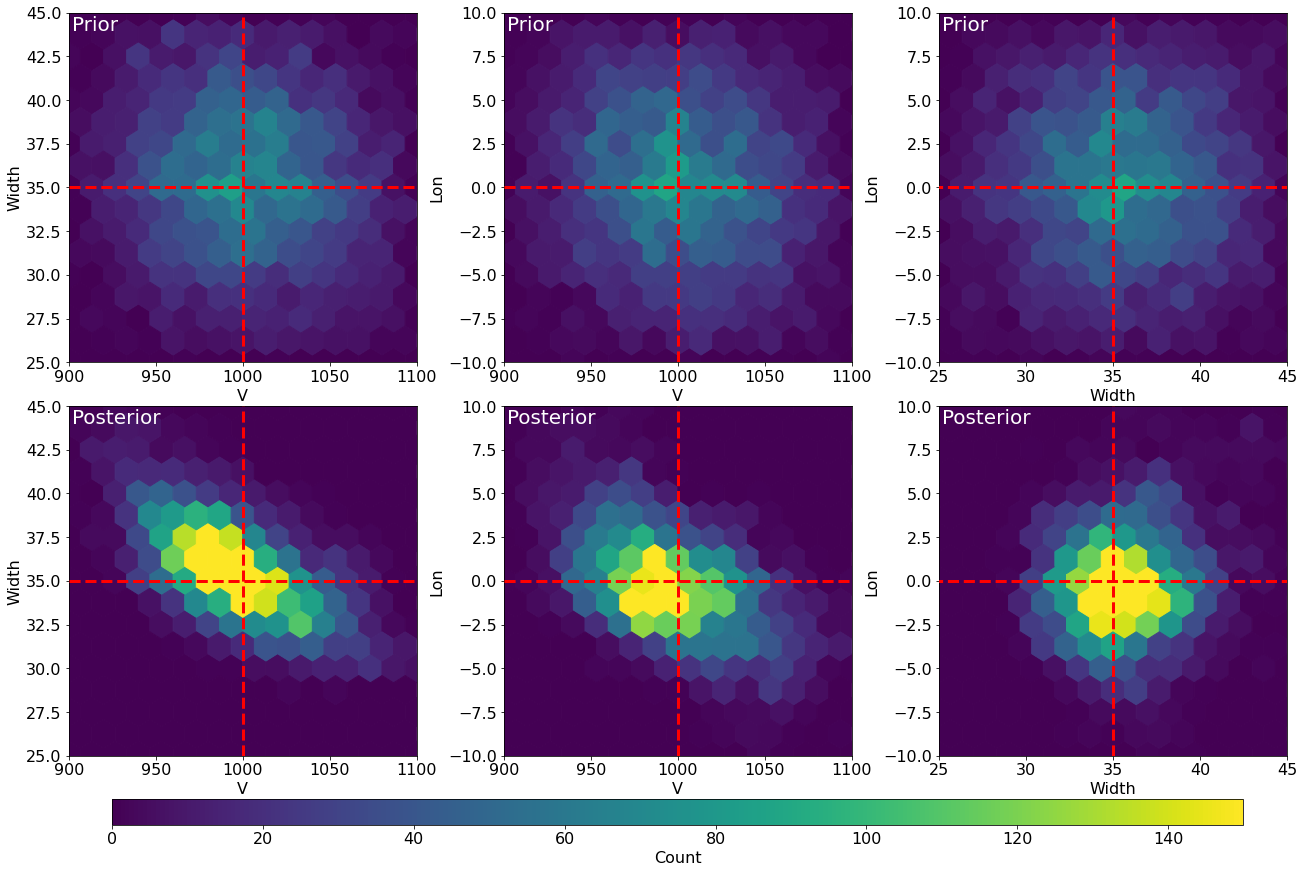

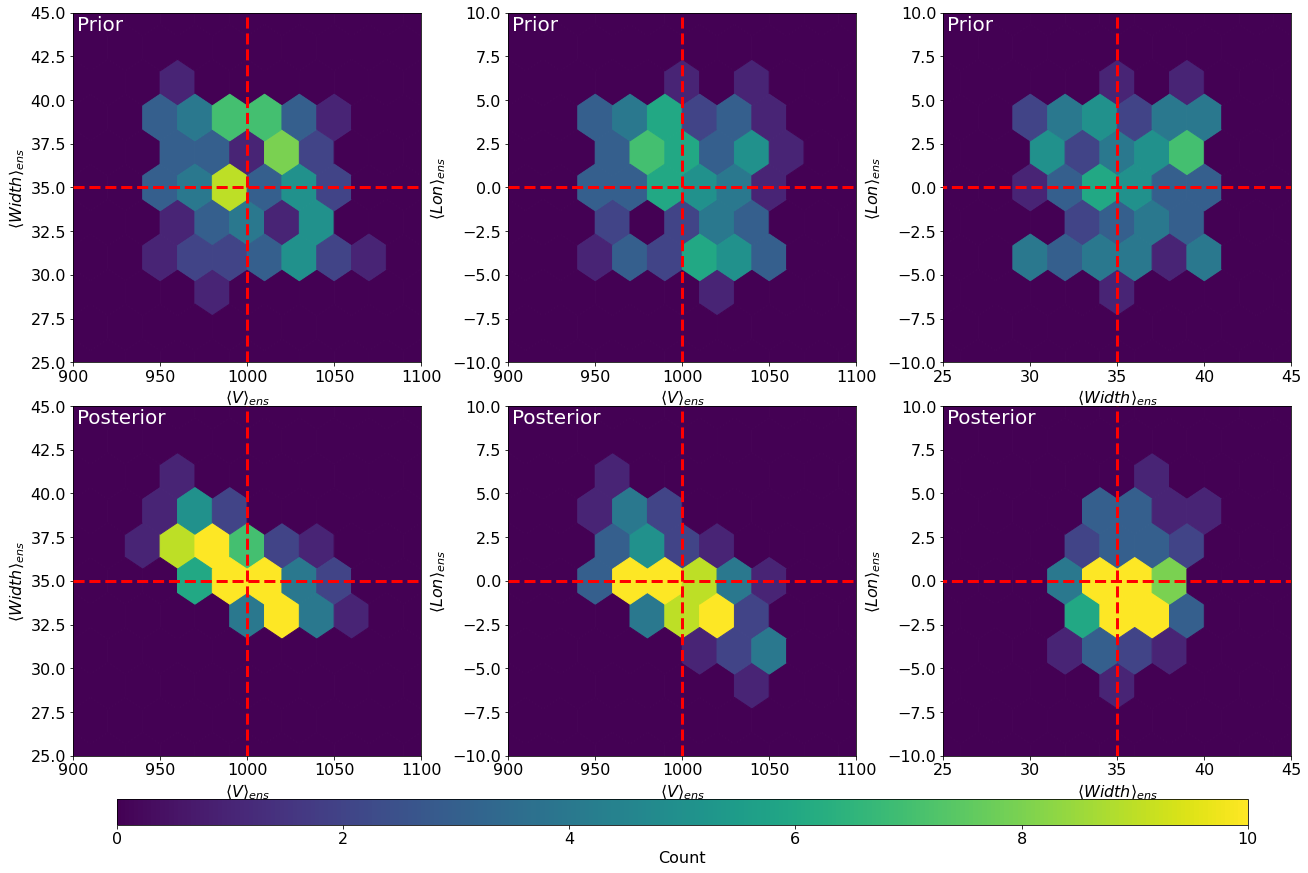

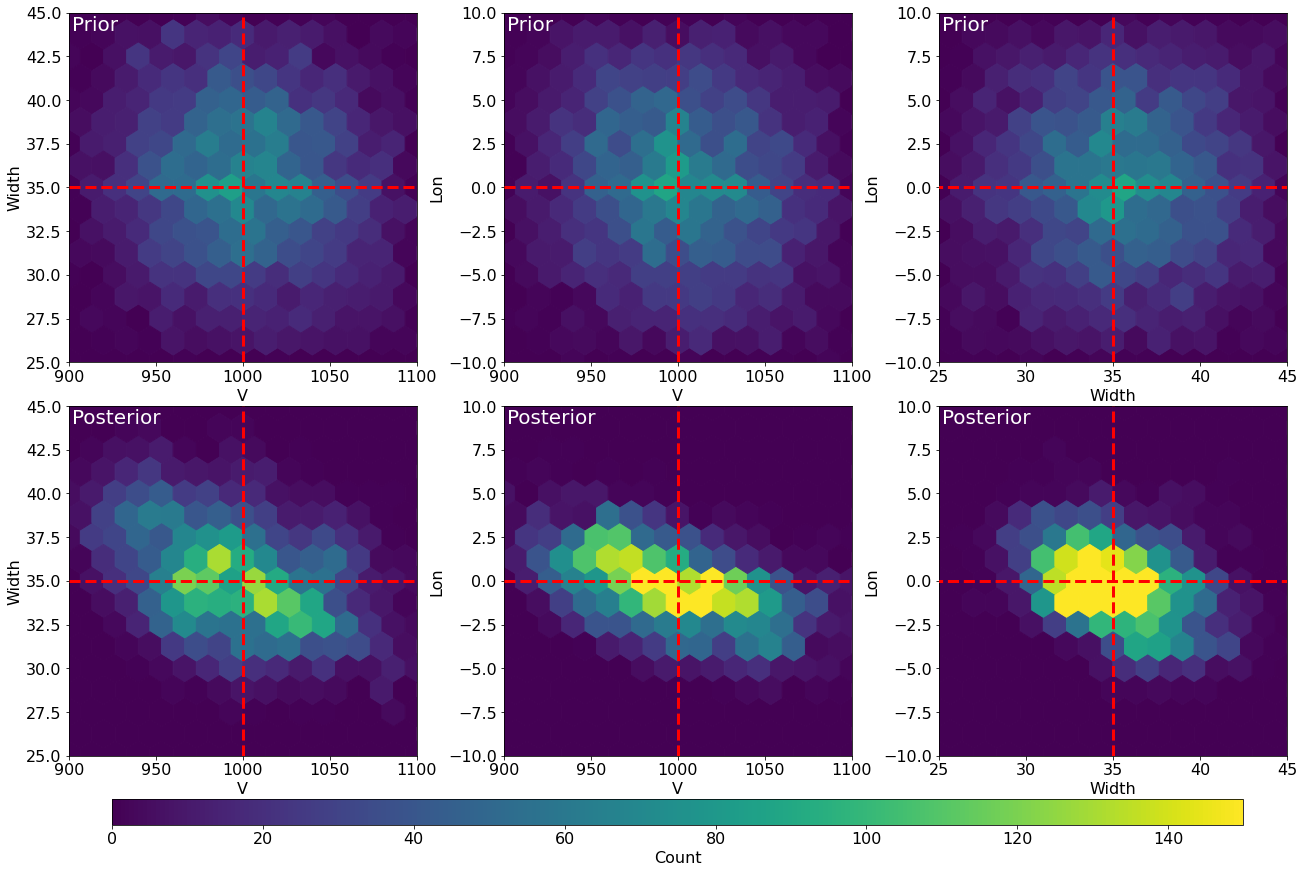

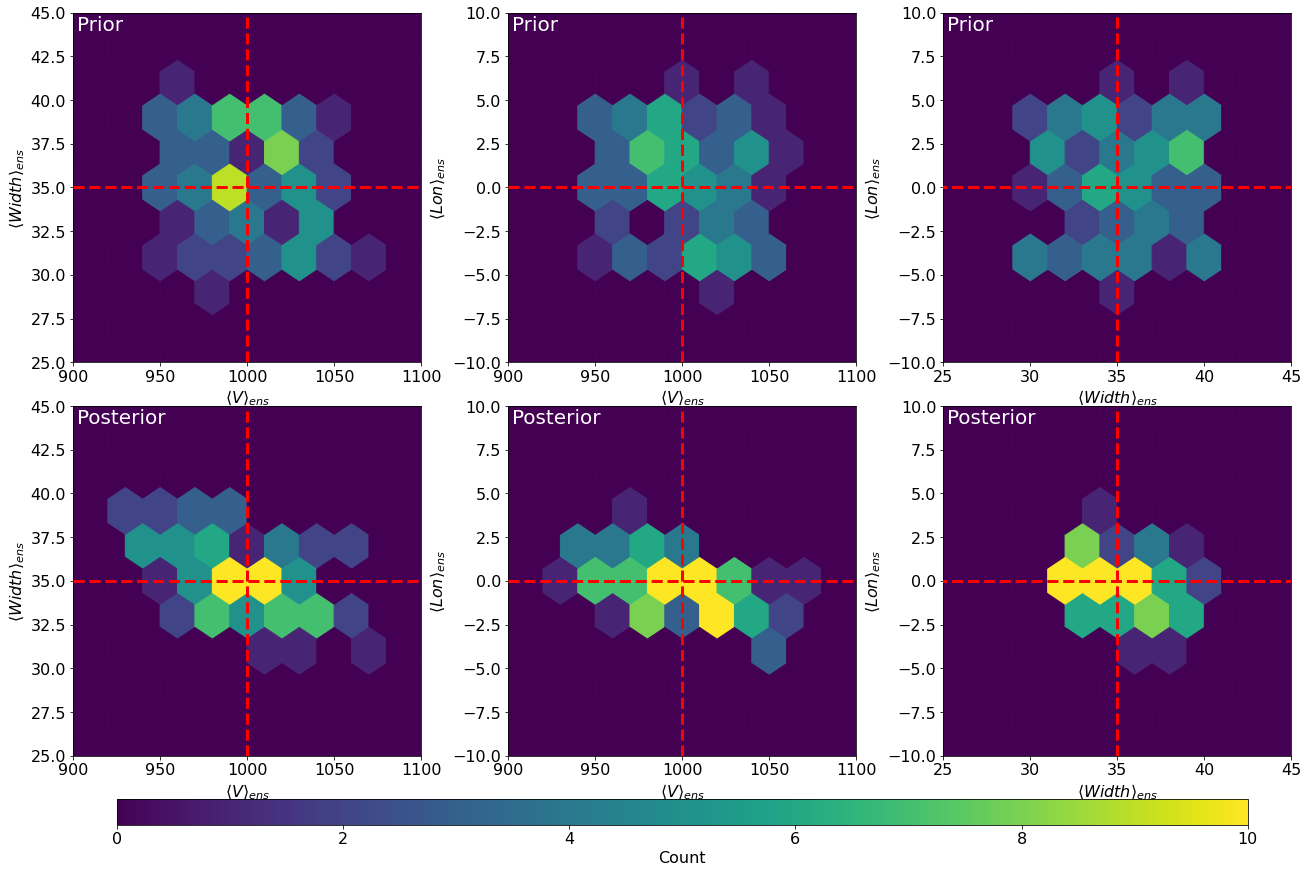

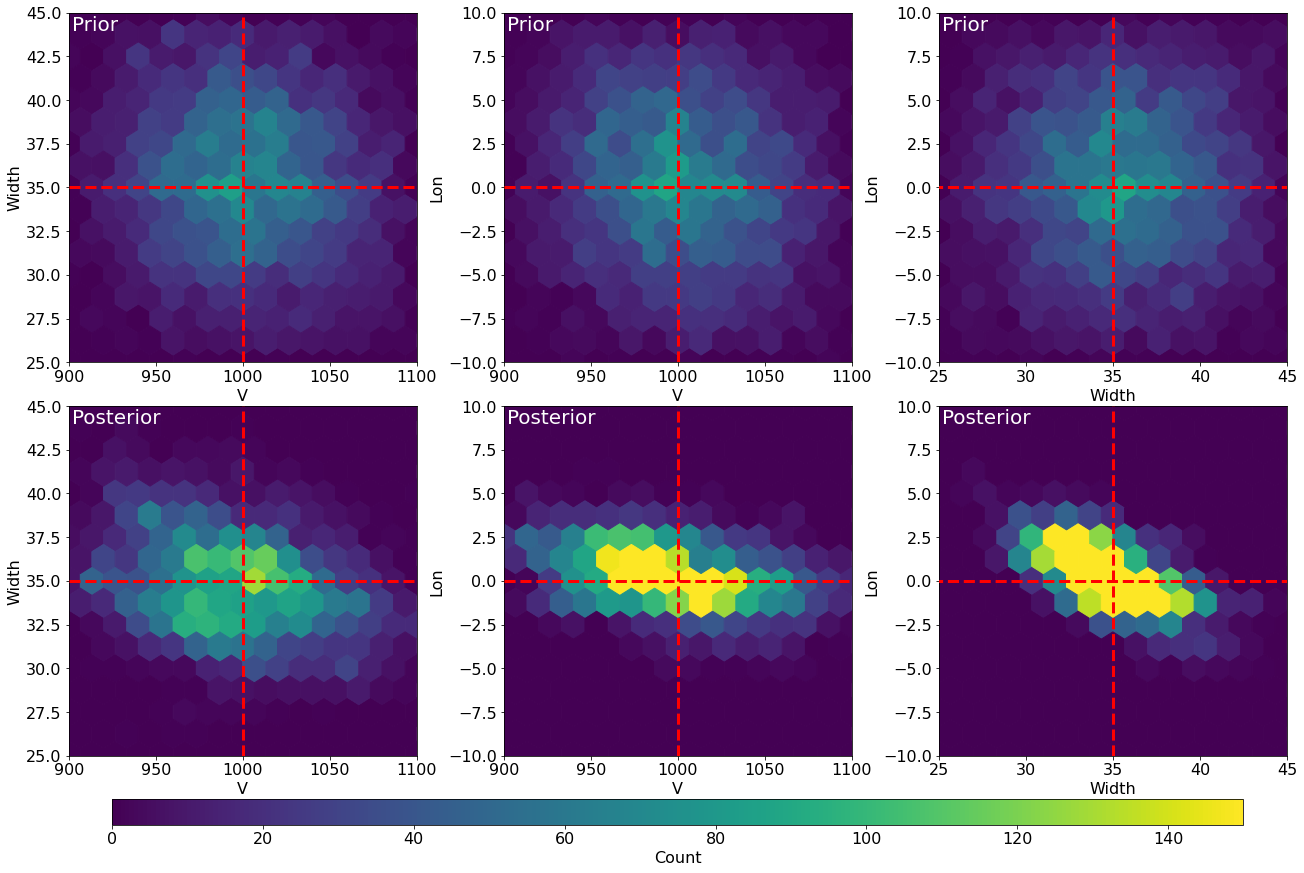

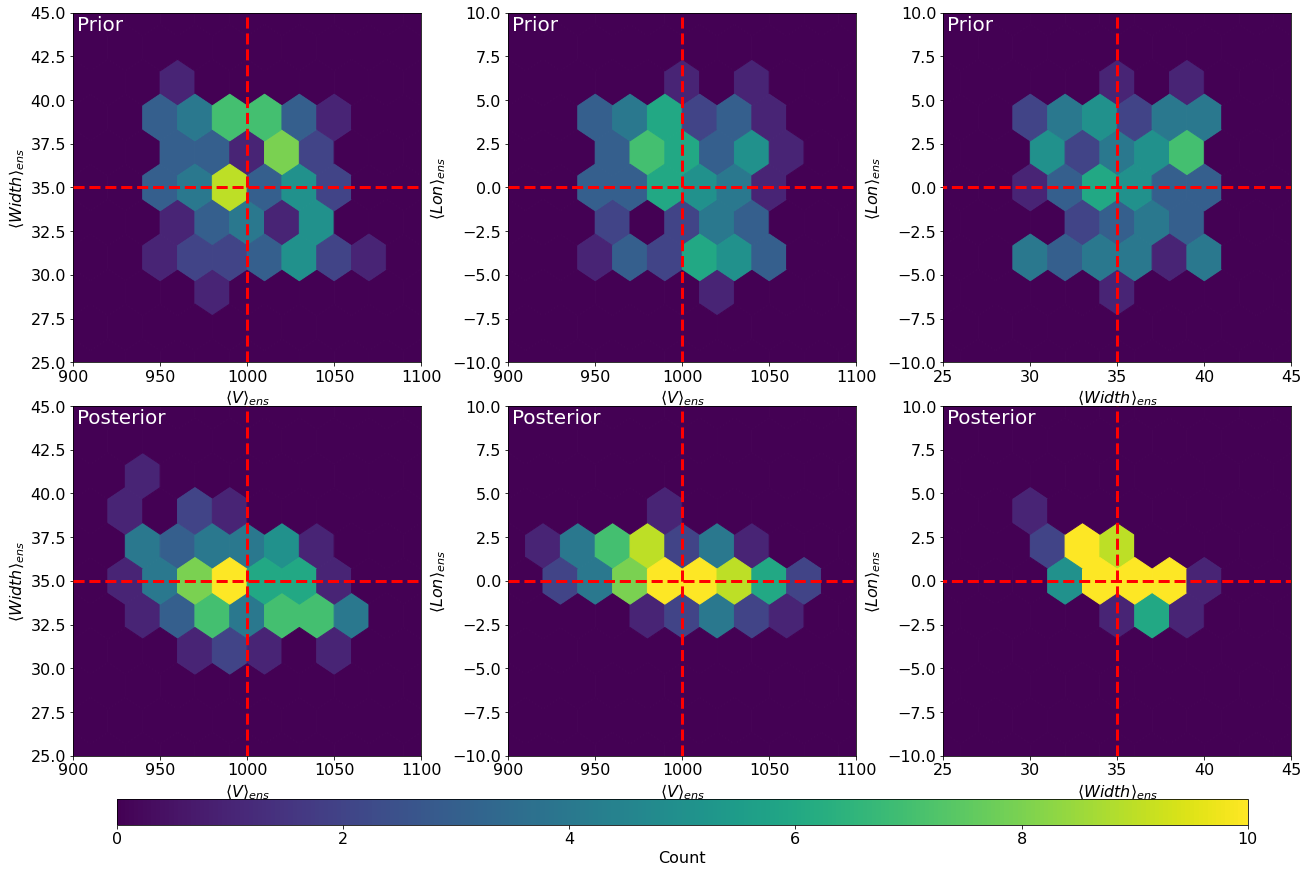

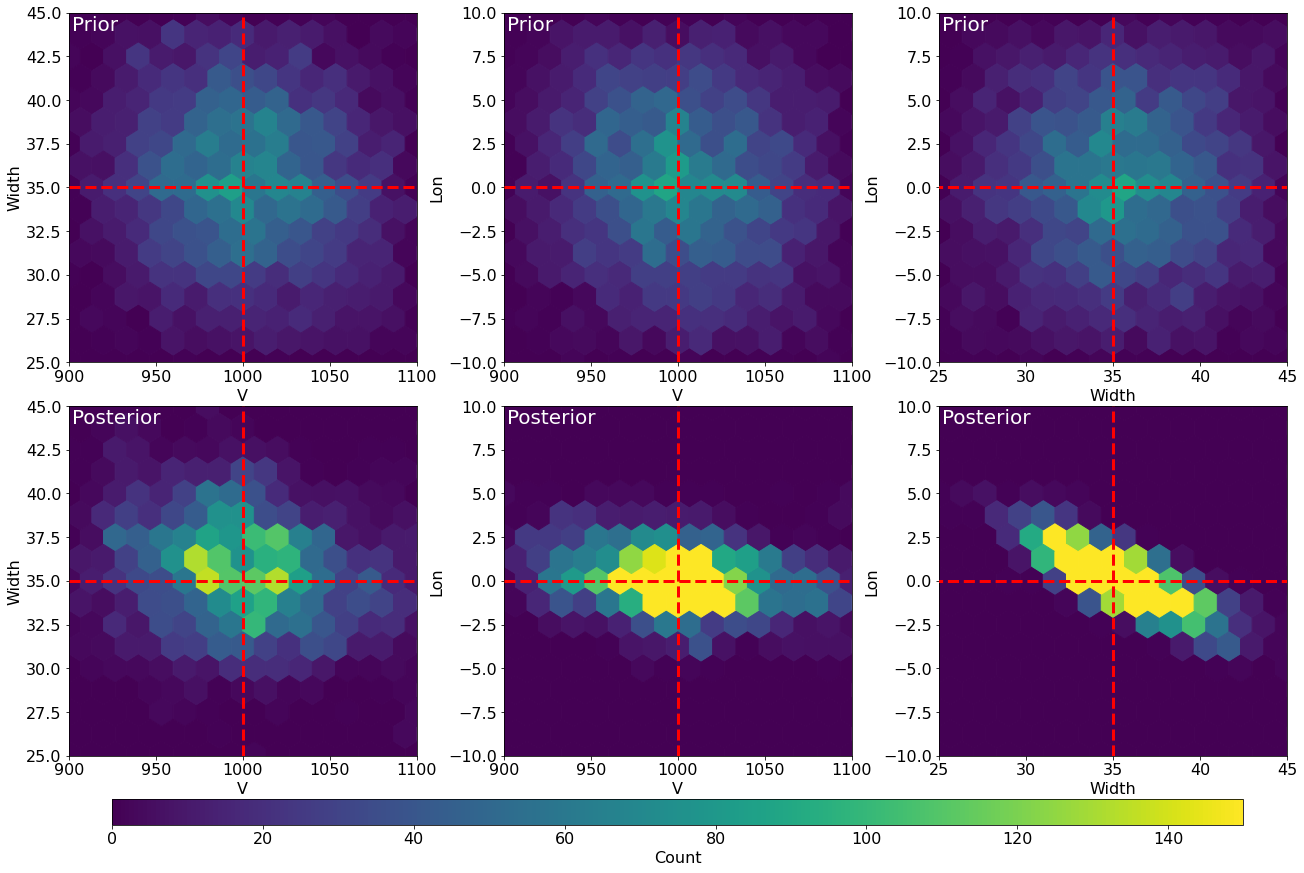

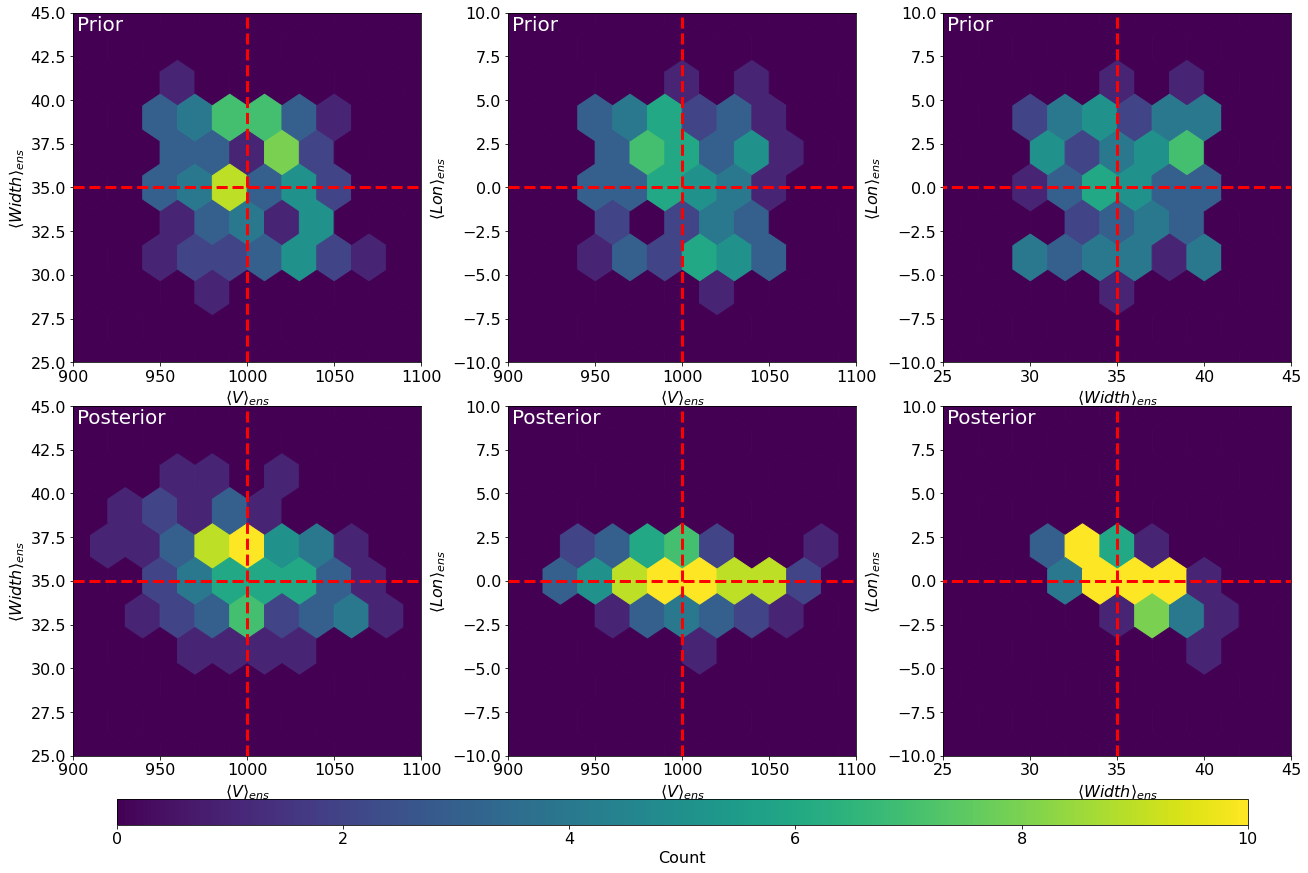

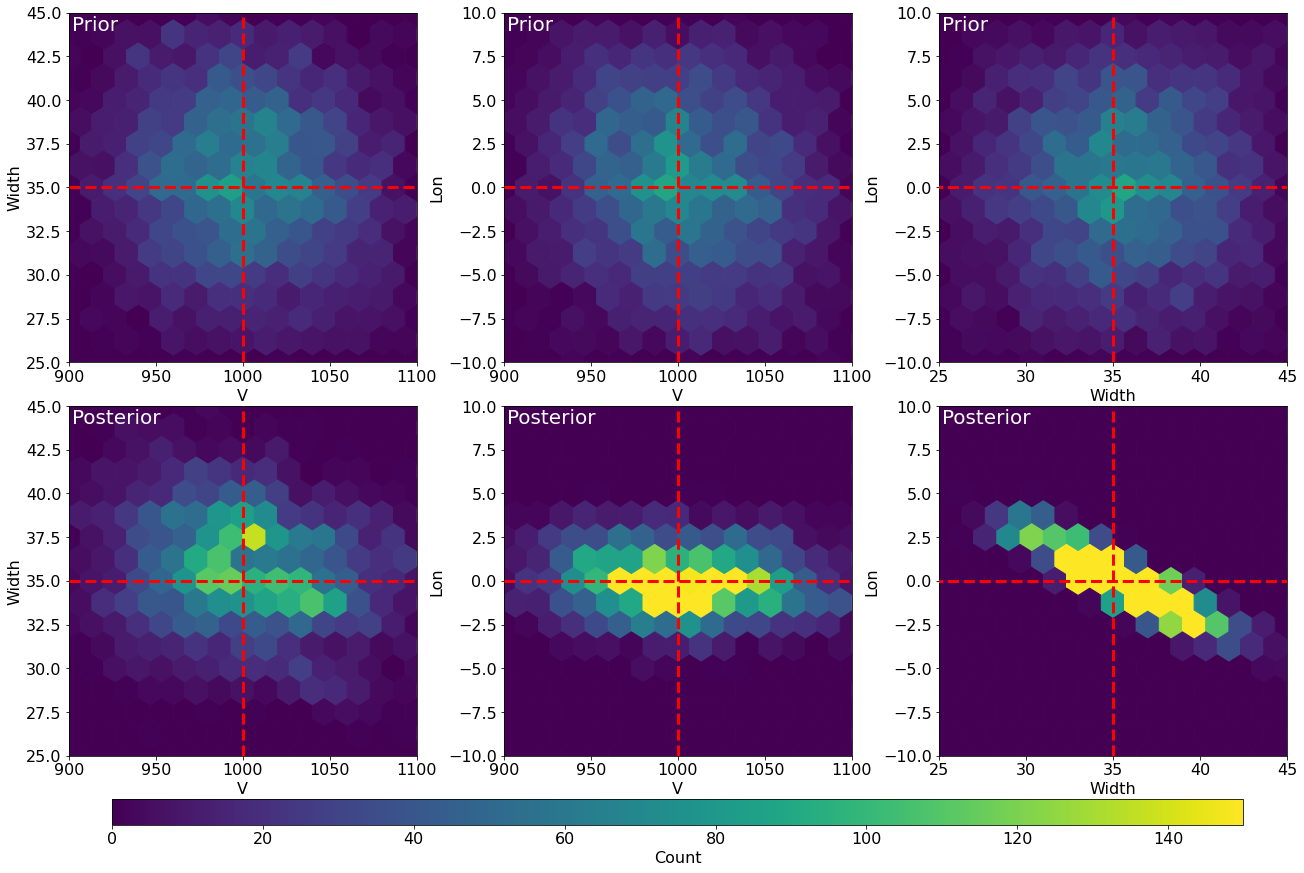

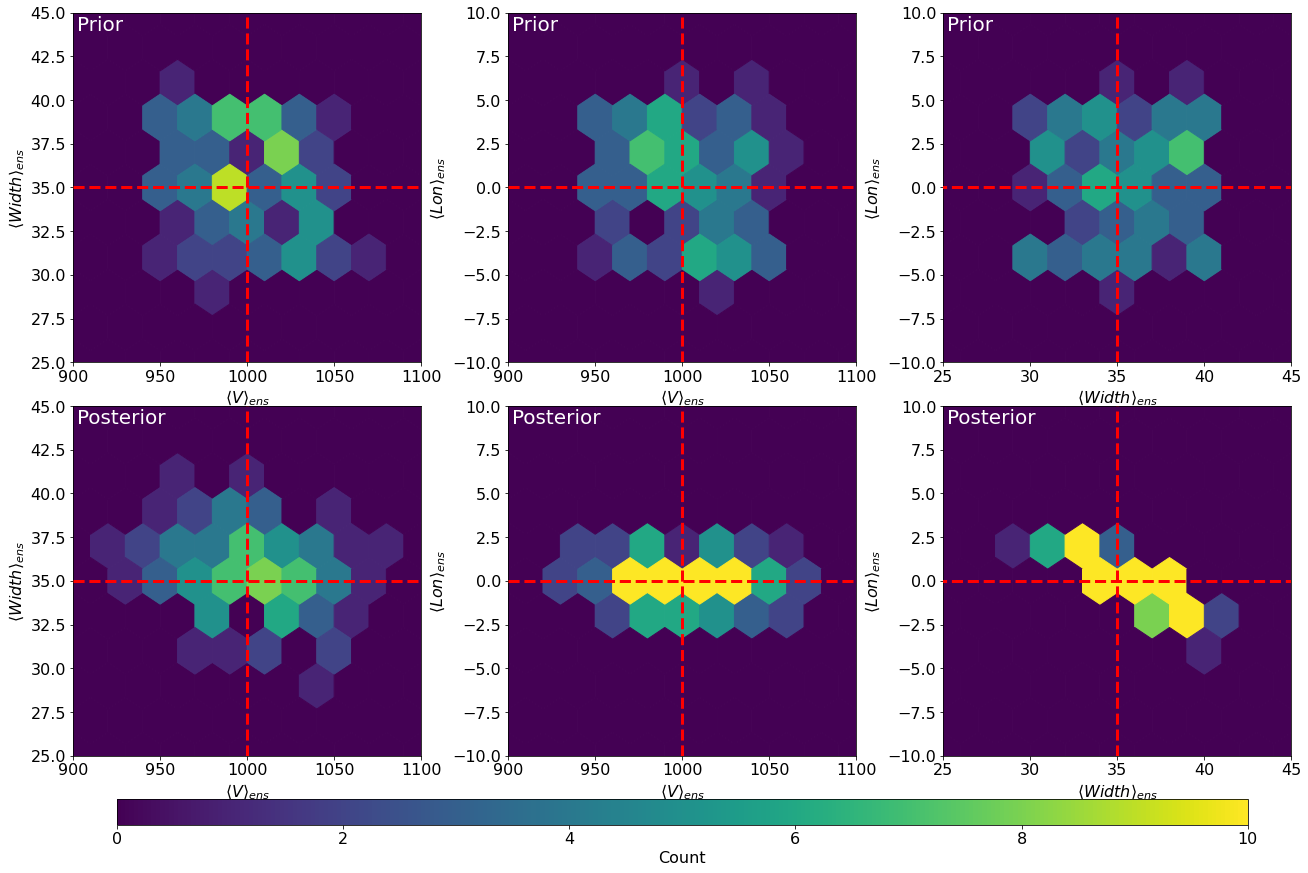

In [3]:
#####
lons = [300, 310, 320, 330, 340]
dirs = sir.get_project_dirs()

for lon in lons:
    dir_tag = 'obs_lon_{}'.format(lon)
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)

    fig1, ax1 = plt.subplots(2, 3, figsize=(18, 12))
    fig2, ax2 = plt.subplots(2, 3, figsize=(18, 12))

    for i, key in enumerate(['prior', 'post']):

        if key == 'prior':
            analysis_key = 'analysis_00'
            fmt = 'k.'
            z=2
        elif key == 'post':
            analysis_key = 'analysis_07'
            fmt = 'r.'
            z=3

        v_bin = []
        width_bin = []
        lon_bin = []

        v_avg_bin = []
        width_avg_bin = []
        lon_avg_bin = []
        bad_count = 0
        for f in files: 

            out_file = h5py.File(f, 'r')
            if analysis_key not in out_file.keys():
                bad_count += 1
                continue

            cme_truth_params = out_file['truth_cme_params'][:]
            lon_truth = np.rad2deg(cme_truth_params[1])
            width_truth = np.rad2deg(cme_truth_params[3])
            v_truth = cme_truth_params[4]
            w = out_file[analysis_key]['weight'][()]
            id_best = np.argmax(w)

            if lon_truth > 180:
                lon_truth -= 360

            vf = out_file[analysis_key]['v'][:]
            v_bin.append(vf)
            v_avg_bin.append(np.mean(vf))
            wf= out_file[analysis_key]['width'][:]
            width_bin.append(wf)
            width_avg_bin.append(np.mean(wf))
            lf = out_file[analysis_key]['lon'][:]
            lf[lf>180] -= 360
            lon_bin.append(lf)
            lon_avg_bin.append(np.mean(lf))

            out_file.close()

        v_bin = np.array(v_bin).ravel()
        width_bin = np.array(width_bin).ravel()
        lon_bin = np.array(lon_bin).ravel()    

        v_avg_bin = np.array(v_avg_bin).ravel()
        width_avg_bin = np.array(width_avg_bin).ravel()
        lon_avg_bin = np.array(lon_avg_bin).ravel()    

        vwlims = (900, 1100, 25, 45)
        vllims = (900, 1100, -10, 10)
        wllims = (25, 45, -10, 10)
        vmin = 0
        vmax = 150
        cmap = 'viridis'
        ax1[i, 0].hexbin(v_bin, width_bin, gridsize=15, extent=vwlims, vmin=vmin, vmax=vmax, cmap=cmap)
        ax1[i, 1].hexbin(v_bin, lon_bin, gridsize=15, extent=vllims, vmin=vmin, vmax=vmax, cmap=cmap)
        hb1 = ax1[i, 2].hexbin(width_bin, lon_bin, gridsize=15, extent=wllims, vmin=vmin, vmax=vmax, cmap=cmap)

        vmin = 0
        vmax = 10
        ax2[i, 0].hexbin(v_avg_bin, width_avg_bin, gridsize=10, extent=vwlims, vmin=vmin, vmax=vmax, cmap=cmap)
        ax2[i, 1].hexbin(v_avg_bin, lon_avg_bin, gridsize=10, extent=vllims, vmin=vmin, vmax=vmax, cmap=cmap)
        hb2 = ax2[i, 2].hexbin(width_avg_bin, lon_avg_bin, gridsize=10, extent=wllims, vmin=vmin, vmax=vmax, cmap=cmap)

    ##############################
    # FORMAT AXIS1

    for a in ax1[:,0]:
        a.vlines(v_truth, vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(width_truth, vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('V')
        a.set_ylabel('Width')

    for a in ax1[:, 1]:
        a.vlines(v_truth, -10, 10, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(lon_truth, 900, 1100, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(900, 1100)
        a.set_ylim(-10, 10)
        a.set_xlabel('V')
        a.set_ylabel('Lon')

    for a in ax1[:, 2]:
        a.vlines(width_truth, -10, 10, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(lon_truth, 20, 50, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(25, 45)
        a.set_ylim(-10, 10)
        a.set_xlabel('Width')
        a.set_ylabel('Lon')

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax1.shape[1]):
            ax1[i, j].text(0.01, 0.95, lab, fontsize=20, color='w', transform=ax1[i, j].transAxes)

    fig1.subplots_adjust(left=0.05, bottom=0.13, right=0.99, top=0.99, wspace=0.25, hspace=0.125)

    pos1 = ax1[1,0].get_position()
    pos2 = ax1[1,2].get_position()
    dw = 0.005
    dh = 0.08
    left = pos1.x0 + pos1.width/8
    right = pos2.x1 - pos2.width/8
    wid = right - left
    bottom = pos1.y0 - dh
    cbaxes = fig1.add_axes([left, bottom, wid, 0.03])
    cbar1 = fig1.colorbar(hb1, cax=cbaxes, orientation='horizontal')
    cbar1.set_label('Count')

    ##############################
    # FORMAT AXIS2

    for a in ax2[:,0]:
        a.vlines(v_truth, vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(width_truth, vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(vwlims[0], vwlims[1])
        a.set_ylim(vwlims[2], vwlims[3]) 
        a.set_xlabel('$\\langle V \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Width \\rangle_{{ens}}$')

    for a in ax2[:, 1]:
        a.vlines(v_truth, -10, 10, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(lon_truth, 900, 1100, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(900, 1100)
        a.set_ylim(-10, 10)
        a.set_xlabel('$\\langle V \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$')

    for a in ax2[:, 2]:
        a.vlines(width_truth, -10, 10, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.hlines(lon_truth, 20, 50, zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
        a.set_xlim(25, 45)
        a.set_ylim(-10, 10)
        a.set_xlabel('$\\langle Width \\rangle_{{ens}}$')
        a.set_ylabel('$\\langle Lon \\rangle_{{ens}}$')

    labels = ['Prior', 'Posterior']
    for i, lab in enumerate(labels):
        for j in range(ax2.shape[1]):
            ax2[i, j].text(0.01, 0.95, lab, fontsize=20, color='w', transform=ax2[i, j].transAxes)

    fig2.subplots_adjust(left=0.05, bottom=0.13, right=0.99, top=0.99, wspace=0.25, hspace=0.125)

    pos1 = ax2[1,0].get_position()
    pos2 = ax2[1,2].get_position()
    dw = 0.005
    dh = 0.08
    left = pos1.x0 + pos1.width/8
    right = pos2.x1 - pos2.width/8
    wid = right - left
    bottom = pos1.y0 - dh
    cbaxes = fig2.add_axes([left, bottom, wid, 0.03])
    cbar1 = fig2.colorbar(hb2, cax=cbaxes, orientation='horizontal')
    cbar1.set_label('Count')

    dirs = sir.get_project_dirs()
    name = 'fig_1_particle_density_{}.png'.format(dir_tag)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path)

    name = 'fig_2_mean_particle_density_{}.png'.format(dir_tag)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path)

    print(bad_count)

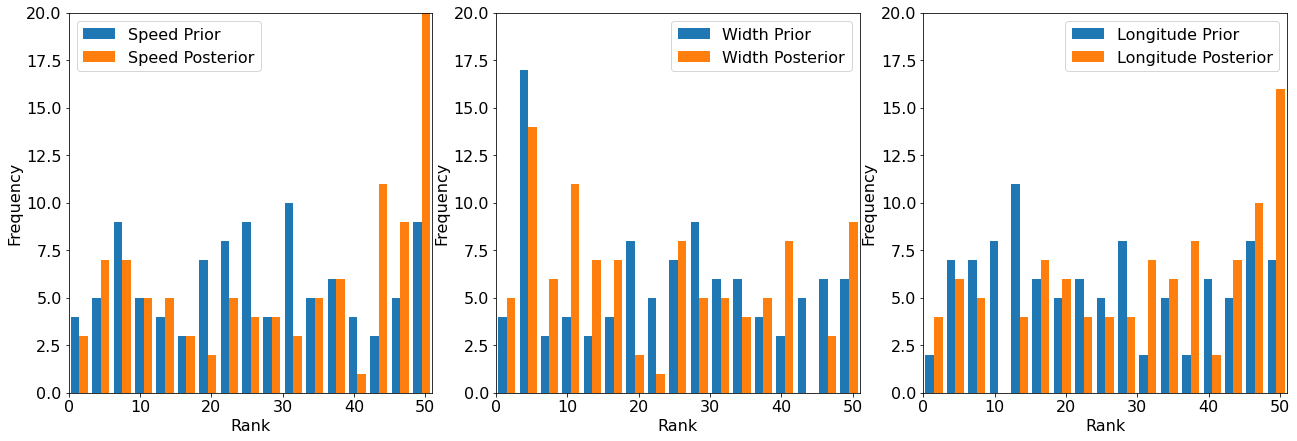

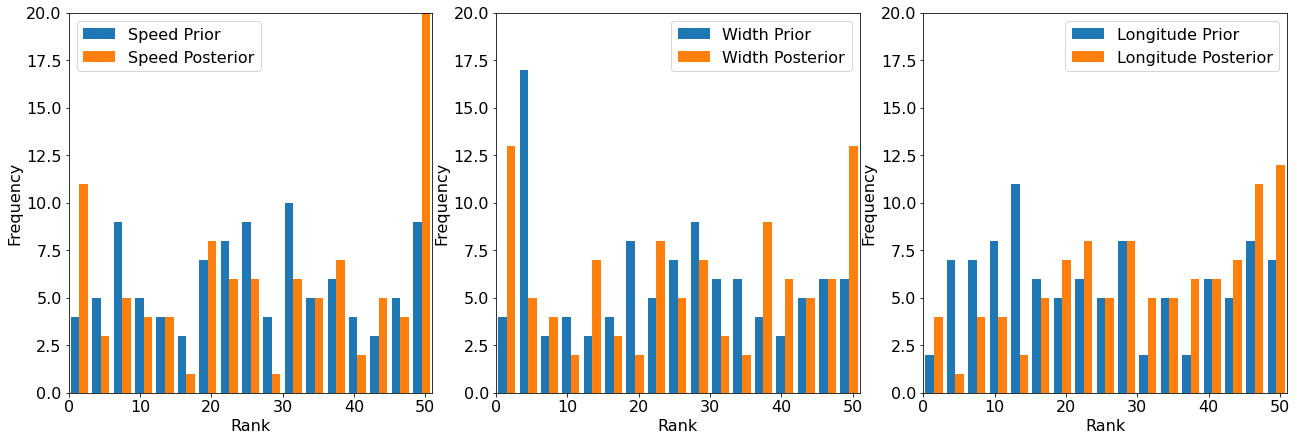

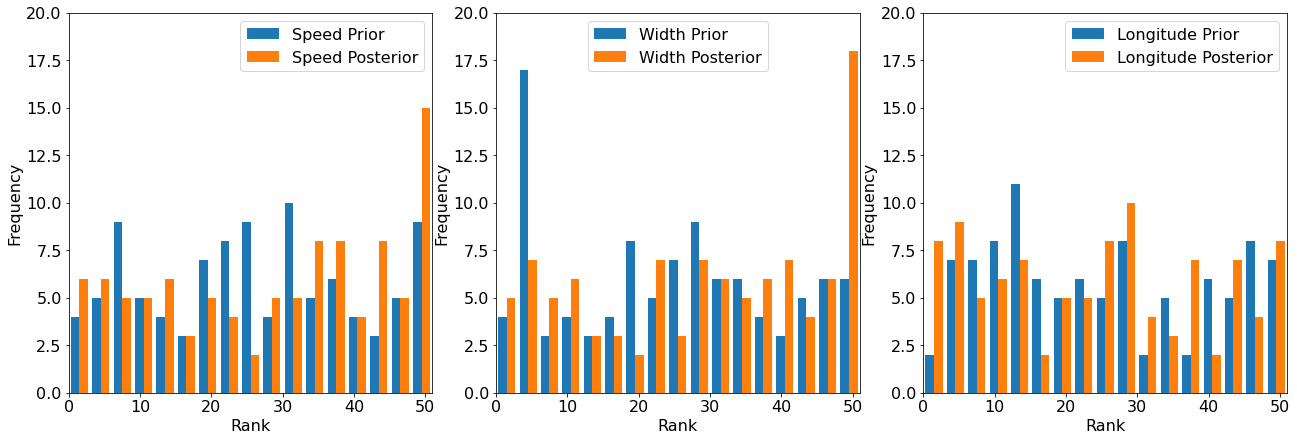

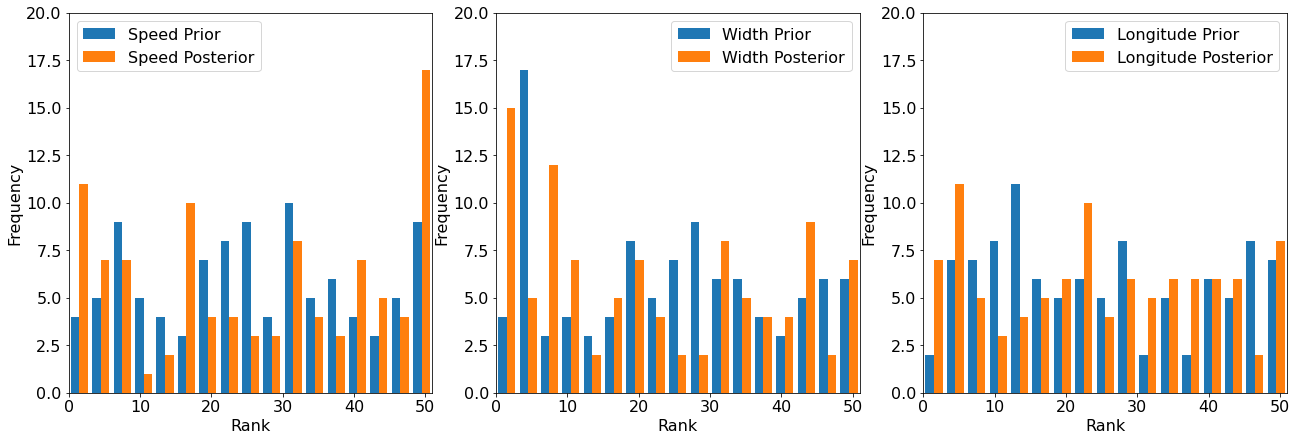

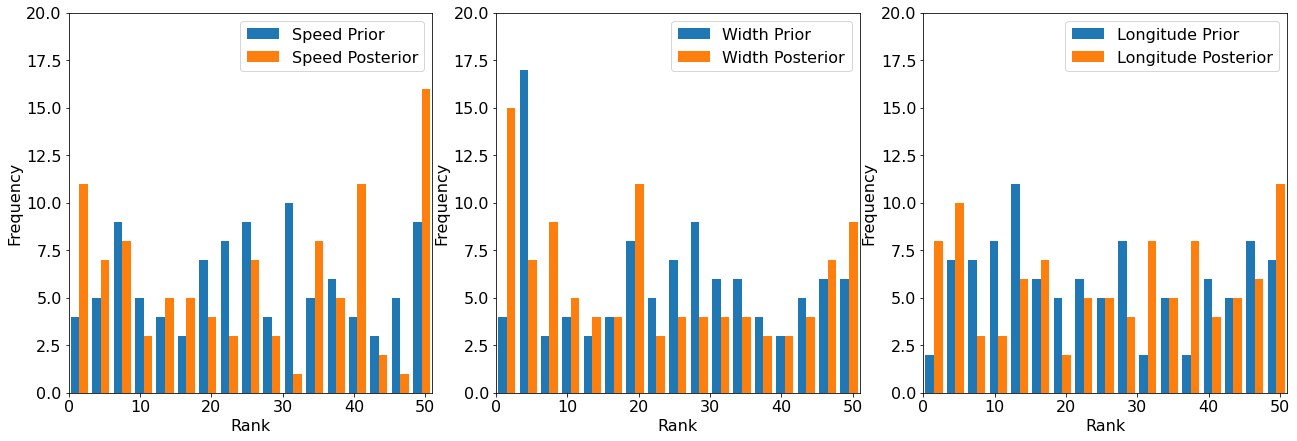

In [4]:
lons = [300, 310, 320, 330, 340]
dirs = sir.get_project_dirs()

for lon in lons:
    dir_tag = 'obs_lon_{}'.format(lon)
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)
    
    # Get ranks and ensemble means of the priors
    v_rank_prior = [] 
    v_avg_prior = []

    ess_prior = []

    params = ['v_truth', 'v_avg', 'v_rank', 'v_std',
              'width_truth', 'width_avg', 'width_rank', 'width_std',
              'lon_truth', 'lon_avg', 'lon_rank', 'lon_std',
              'ess']

    data = {key: {param_key:[] for param_key in params} for key in ['prior', 'post']}

    for key in ['prior', 'post']:

        if key == 'prior':
            analysis_key = 'analysis_00'
        elif key == 'post':
            analysis_key = 'analysis_07'

        for f in files: 

            out_file = h5py.File(f, 'r')
            if analysis_key not in out_file.keys():
                bad_count += 1
                continue

            cme_truth_params = out_file['truth_cme_params'][:]
            data[key]['lon_truth'] = np.rad2deg(cme_truth_params[1])
            data[key]['width_truth'] = np.rad2deg(cme_truth_params[3])
            data[key]['v_truth'] = cme_truth_params[4]

            w = out_file[analysis_key]['weight'][()]
            ess = 1 / np.sum(w**2)
            data[key]['ess'].append(ess)

            if data[key]['lon_truth'] > 180:
                data[key]['lon_truth'] -= 360

            for param in ['v', 'lon', 'width']:

                # Rank the truth amongst prior ensemble
                # Speed first
                vals = out_file[analysis_key][param][:]
                n_ens = len(vals)
                if param == 'lon':
                    vals[vals>180] -= 360

                val_truth = data[key][param + '_truth']
                vals_all = np.append(vals, val_truth)
                vals_ranks = st.rankdata(vals_all)
                data[key][param + '_rank'].append(vals_ranks[-1])
                # Ensemble mean of prior
                data[key][param + '_avg'].append(np.mean(vals))
                data[key][param + '_std'].append(np.std(vals))

            out_file.close()

    # Produce rank-histograms and dist of ensemble mean
    bins = np.arange(-3, n_ens + 3, 3)
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    for i, (param, label) in enumerate(zip(['v', 'width', 'lon'], ['Speed', 'Width', 'Longitude'])):

        ranks = [data['prior'][param + '_rank'], data['post'][param + '_rank']]
        val_pri = data['prior'][param + '_avg']
        val_pos = data['post'][param + '_avg']
        val_truth = data['prior'][param + '_truth']         

        ax[i].hist(ranks, bins=bins, label=[label+ ' Prior', label + ' Posterior'])

        ax[i].set_xlim(0,51)
        ax[i].set_ylim(0,20)
        ax[i].set_xlabel('Rank')
        ax[i].set_ylabel('Frequency')

        ax[i].legend()


    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.98, wspace=0.175)
    name = 'fig_3_rank_hist_{}'.format(dir_tag)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path)

Speed: 046/100
Width: 060/100
Lon: 080/100
Speed: 046/100
Width: 060/100
Lon: 080/100
Speed: 046/100
Width: 060/100
Lon: 080/100
Speed: 046/100
Width: 060/100
Lon: 080/100
Speed: 046/100
Width: 060/100
Lon: 080/100


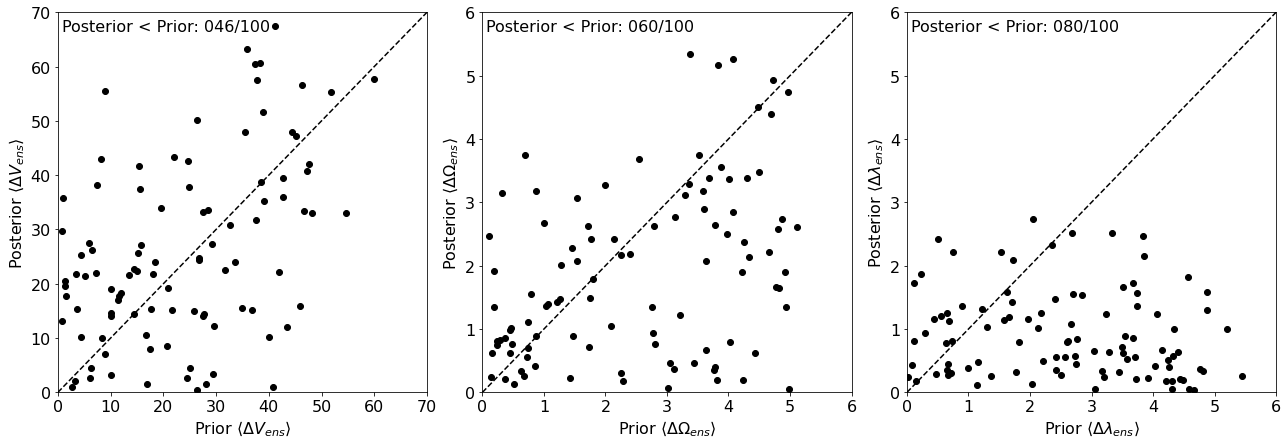

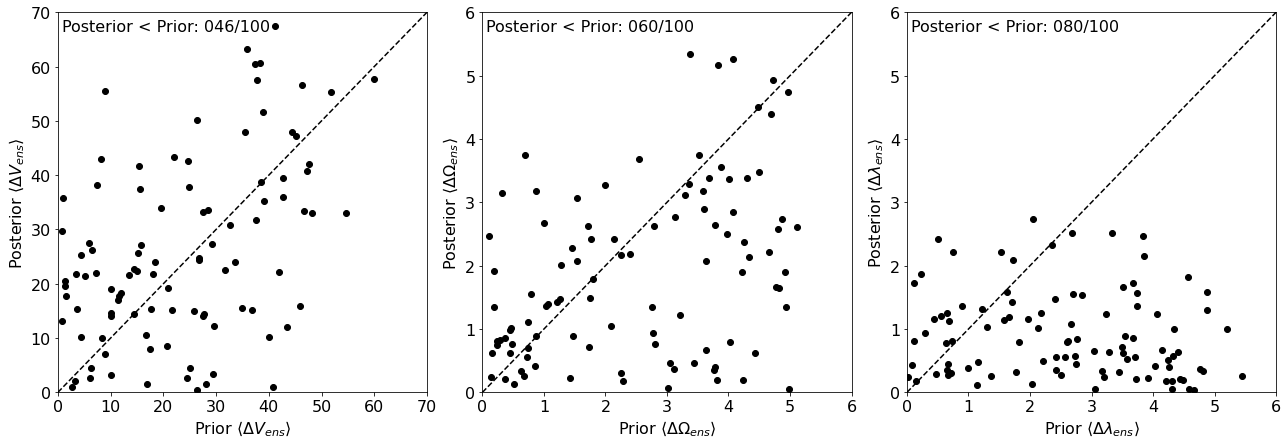

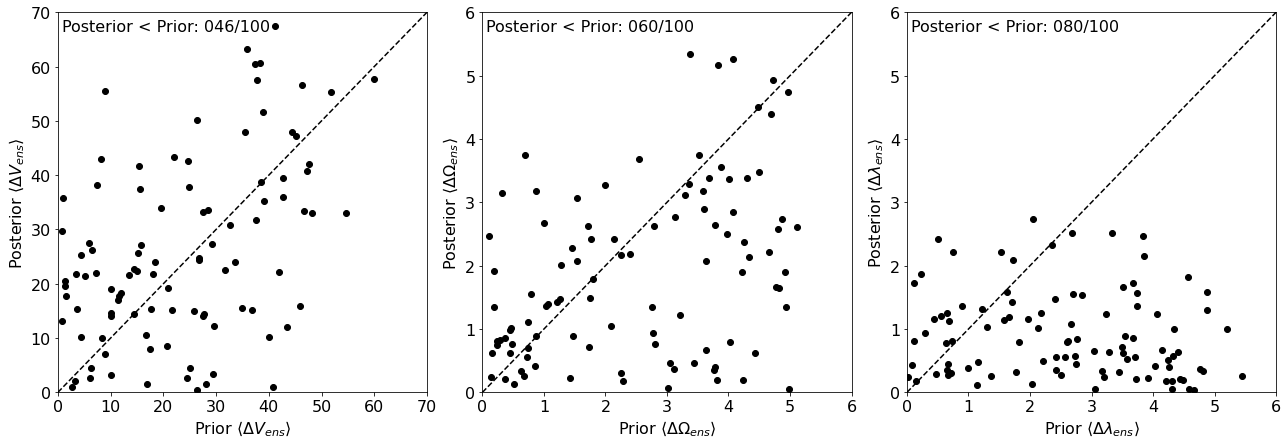

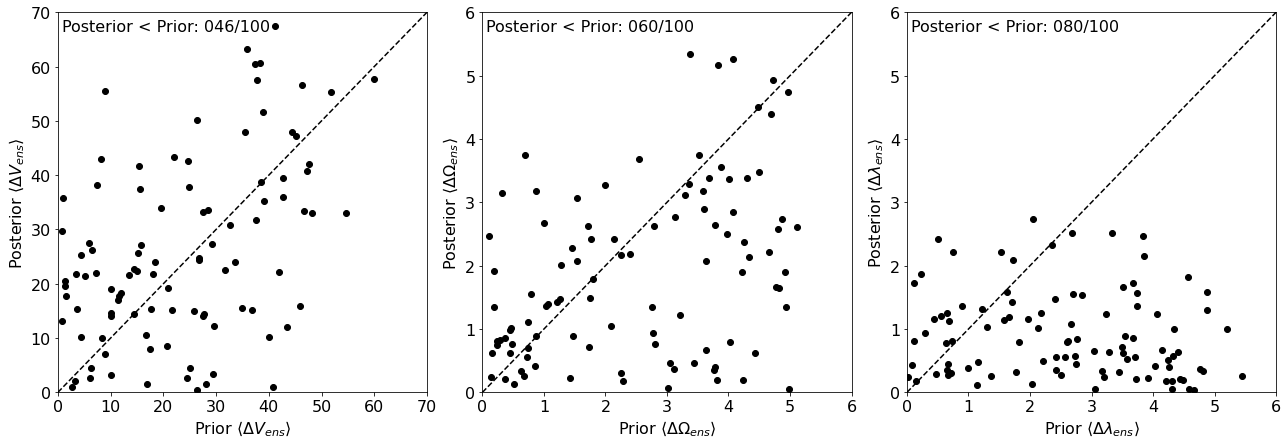

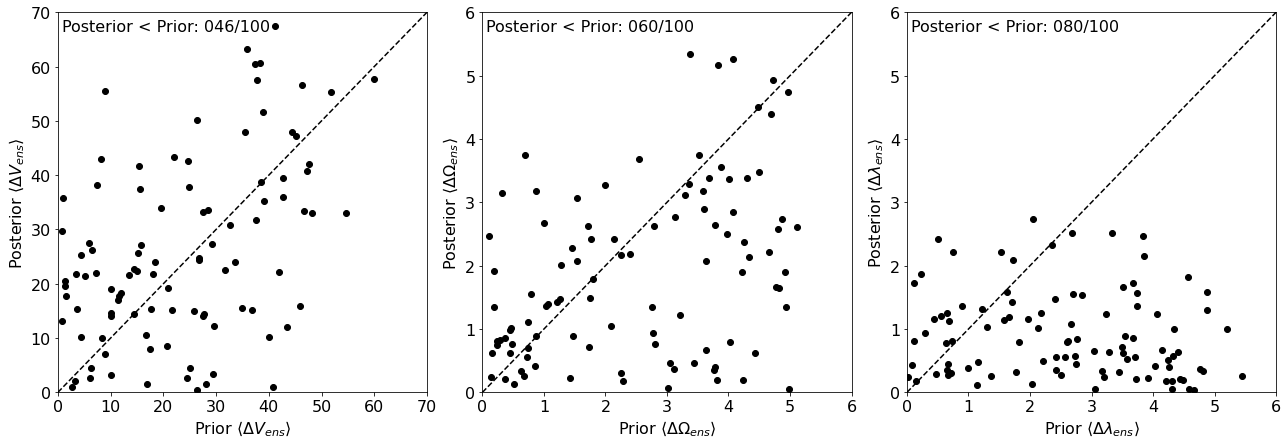

In [5]:
lons = [300, 310, 320, 330, 340]
dirs = sir.get_project_dirs()

for lon in lons:
    dir_tag = 'obs_lon_{}'.format(lon)
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    dv_pri = np.abs(np.array(data['prior']['v_avg']) - 1000)
    dv_pos = np.abs(np.array(data['post']['v_avg']) - 1000)

    count = np.sum(dv_pos < dv_pri)
    tot  = dv_pos.size
    print("Speed: {:03d}/{:03d}".format(count, tot))
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    ax[0].text(0.01, 0.95, txt, fontsize=16, transform=ax[0].transAxes)

    ax[0].plot(dv_pri, dv_pos, 'ko')
    ax[0].plot([0, 100], [0, 100],'k--')
    ax[0].set_xlim(0, 70)
    ax[0].set_ylim(0, 70)

    dw_pri = np.abs(np.array(data['prior']['width_avg']) - 35)
    dw_pos = np.abs(np.array(data['post']['width_avg']) - 35)

    count = np.sum(dw_pos < dw_pri)
    tot = dw_pos.size
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    print("Width: {:03d}/{:03d}".format(count, tot))
    ax[1].text(0.01, 0.95, txt, fontsize=16, transform=ax[1].transAxes)


    ax[1].plot(dw_pri, dw_pos, 'ko')
    ax[1].plot([0, 100], [0, 100],'k--')
    ax[1].set_xlim(0, 6)
    ax[1].set_ylim(0, 6)

    dl_pri = np.abs(np.array(data['prior']['lon_avg']) - 0)
    dl_pos = np.abs(np.array(data['post']['lon_avg']) - 0)

    count = np.sum(dl_pos < dl_pri)
    tot = dl_pos.size
    print("Lon: {:03d}/{:03d}".format(count, tot))
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    ax[2].text(0.01, 0.95, txt, fontsize=16, transform=ax[2].transAxes)

    ax[2].plot(dl_pri, dl_pos, 'ko')
    ax[2].plot([0, 100], [0, 100],'k--')
    ax[2].set_xlim(0, 6)
    ax[2].set_ylim(0, 6)

    for a, lab in zip(ax, ['V', '\\Omega', '\\lambda']):

        a.set_xlabel('Prior $\\langle \\Delta {}_{{ens}}\\rangle$'.format(lab, lab))
        a.set_ylabel('Posterior $\\langle \\Delta {}_{{ens}}\\rangle$'.format(lab, lab))

    fig.subplots_adjust(left=0.04,bottom=0.1, right=0.98, top=0.98, wspace=0.15)

    name = 'fig_4_scatter_avg_{}.png'.format(dir_tag)
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path)



Speed: 068/100
Width: 091/100
Lon: 100/100
Speed: 068/100
Width: 091/100
Lon: 100/100
Speed: 068/100
Width: 091/100
Lon: 100/100
Speed: 068/100
Width: 091/100
Lon: 100/100
Speed: 068/100
Width: 091/100
Lon: 100/100


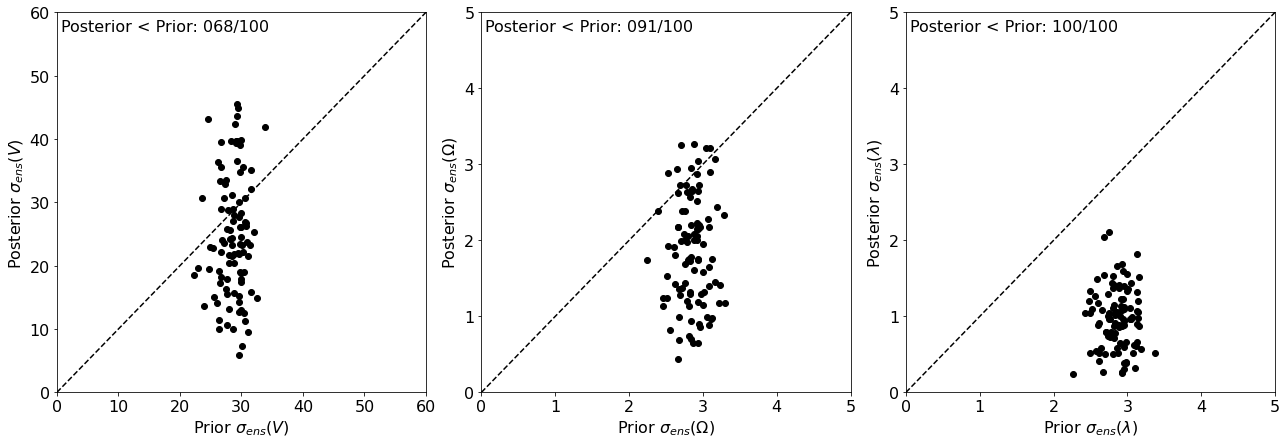

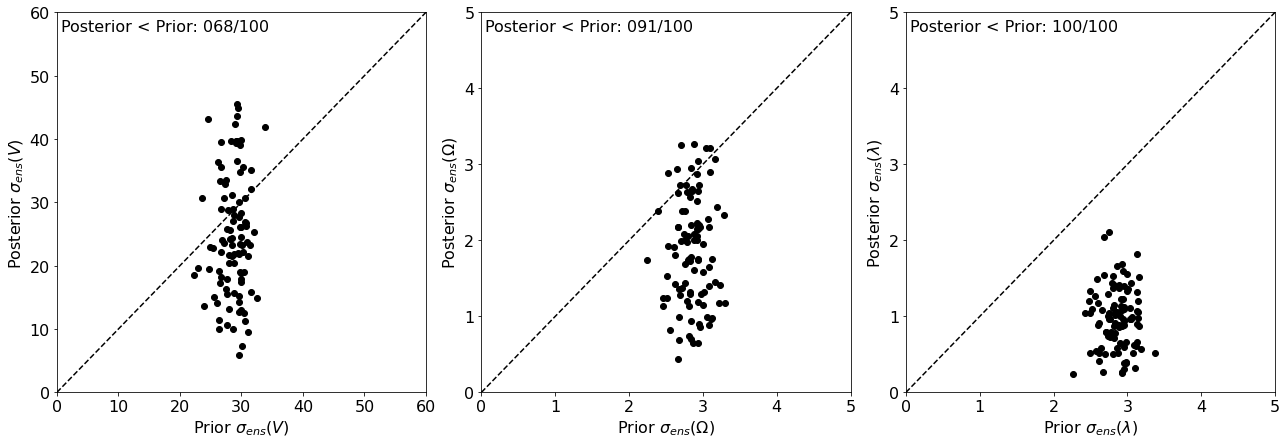

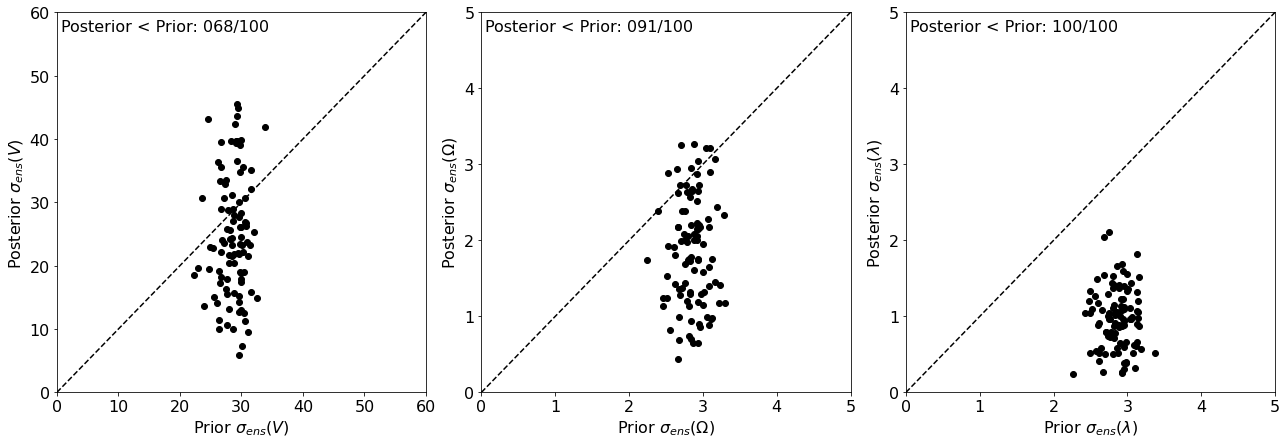

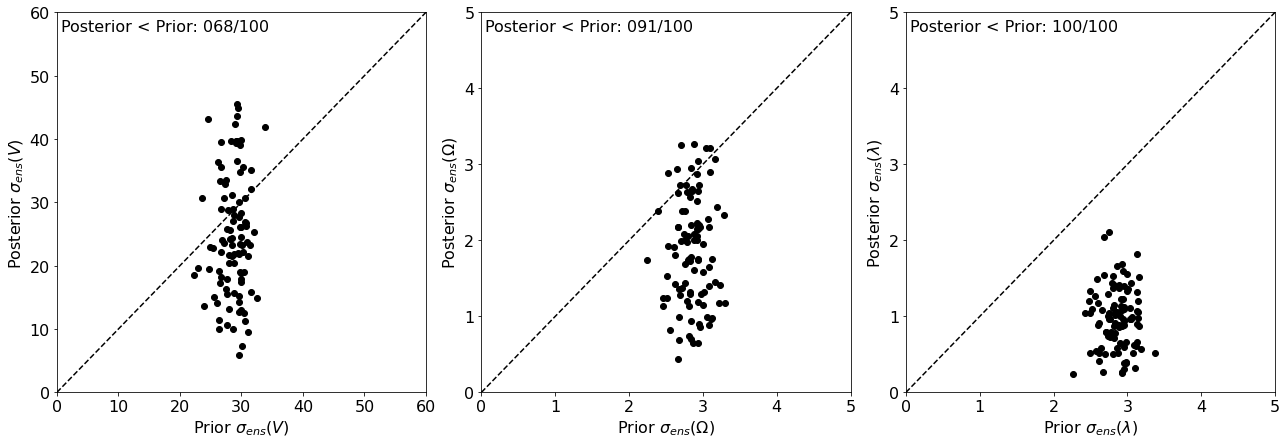

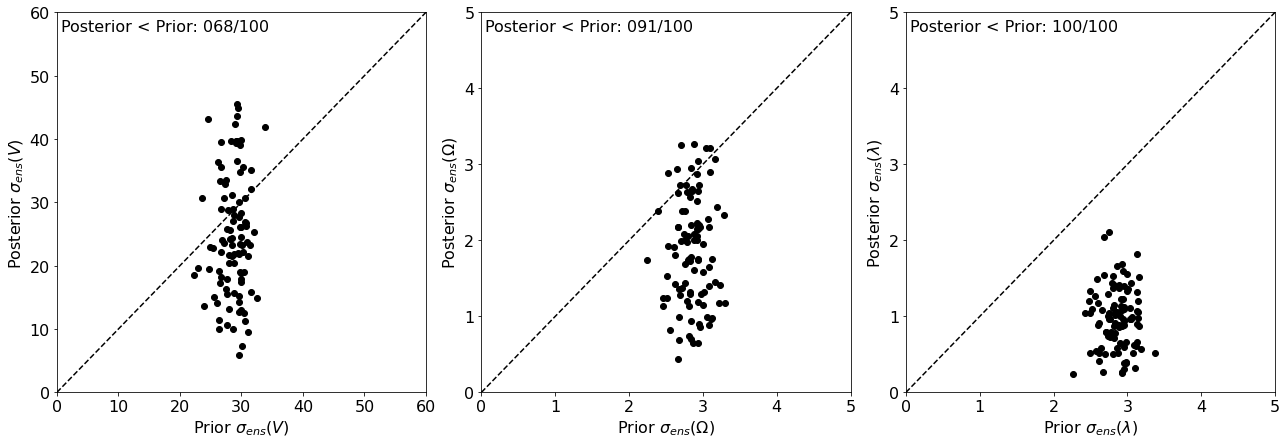

In [6]:
lons = [300, 310, 320, 330, 340]
dirs = sir.get_project_dirs()

for lon in lons:
    dir_tag = 'obs_lon_{}'.format(lon)
    data_dir = os.path.join(dirs['sir_analysis'], dir_tag, "SIR_HUXt_*.hdf5")
    files = glob.glob(data_dir)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    dv_pri = np.array(data['prior']['v_std'])
    dv_pos = np.array(data['post']['v_std'])

    count = np.sum(dv_pos < dv_pri)
    tot  = dv_pos.size
    print("Speed: {:03d}/{:03d}".format(count, tot))
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    ax[0].text(0.01, 0.95, txt, fontsize=16, transform=ax[0].transAxes)

    ax[0].plot(dv_pri, dv_pos, 'ko')
    ax[0].plot([0, 100], [0, 100],'k--')
    ax[0].set_xlim(0, 60)
    ax[0].set_ylim(0, 60)

    dw_pri = np.array(data['prior']['width_std'])
    dw_pos = np.array(data['post']['width_std'])

    count = np.sum(dw_pos < dw_pri)
    tot = dw_pos.size
    print("Width: {:03d}/{:03d}".format(count, tot))
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    ax[1].text(0.01, 0.95, txt, fontsize=16, transform=ax[1].transAxes)

    ax[1].plot(dw_pri, dw_pos, 'ko')
    ax[1].plot([0, 100], [0, 100],'k--')
    ax[1].set_xlim(0, 5)
    ax[1].set_ylim(0, 5)

    dl_pri = np.array(data['prior']['lon_std'])
    dl_pos = np.array(data['post']['lon_std'])

    count = np.sum(dl_pos < dl_pri)
    tot = dl_pos.size
    print("Lon: {:03d}/{:03d}".format(count, tot))
    txt = "Posterior < Prior: {:03d}/{:03d}".format(count, tot)
    ax[2].text(0.01, 0.95, txt, fontsize=16, transform=ax[2].transAxes)


    ax[2].plot(dl_pri, dl_pos, 'ko')
    ax[2].plot([0, 100], [0, 100],'k--')
    ax[2].set_xlim(0, 5)
    ax[2].set_ylim(0, 5)

    for a, lab in zip(ax, ['V', '\\Omega', '\\lambda']):

        a.set_xlabel('Prior $\\sigma_{{ens}}({})$'.format(lab))
        a.set_ylabel('Posterior $\\sigma_{{ens}}({})$'.format(lab))

    fig.subplots_adjust(left=0.04,bottom=0.1, right=0.98, top=0.98, wspace=0.15)

    name = 'fig_5_scatter_spread_{}.png'.format(dir_tag)
    dirs = sir.get_project_dirs()
    out_path = os.path.join(dirs['figures'], name)
    fig.savefig(out_path)
